In [62]:
import os
os.chdir("..")
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import lognorm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler

In [2]:
with open("data/scenario_san_francisco.json") as f:
    data = json.loads(f.read())

In [3]:
df = pd.DataFrame(data["demand"])

# Simple summary stats

In [4]:
df_org_dest = df.groupby(["origin", "destination"]).agg({"price": ["count", "mean"], "demand": "mean", "travel_time":"mean"}).reset_index()

In [5]:
df_org_dest.head()

origin destination price           demand travel_time
                     count   mean      mean        mean
0      0           2    15  10.00  0.066667         4.0
1      0           8    15  46.40  0.066667        31.0
2      1           5    15  16.50  0.133333        10.0
3      1           7    30  31.95  0.066667        18.5
4      2           0    15  10.50  0.066667         5.0

In [37]:
org_dest_pairs = list(df.groupby(["origin","destination"]).count().index)

In [38]:
u_o_d = []
for org, dest in org_dest_pairs:
    if ((org, dest) in u_o_d) or ((dest, org) in u_o_d):
        continue
    u_o_d.append((org,dest))

In [46]:
df_org_dest.sort_values("mean_price", ascending=False)

,Origin,Destination,count,mean_price,mean_demand,mean_travel_time
1,0,8,15,46.400,0.066667,31.0
13,3,6,15,39.400,0.066667,25.0
16,3,9,15,37.500,0.066667,20.0
48,8,2,60,32.325,0.100000,21.0
3,1,7,30,31.950,0.066667,18.5
...,...,...,...,...,...,...
41,7,4,150,11.480,0.166667,6.7
17,4,3,30,10.850,0.066667,6.5
4,2,0,15,10.500,0.066667,5.0
11,3,4,15,10.000,0.066667,4.0


In [6]:
df_org_dest.columns = df_org_dest.columns.droplevel(0)
df_org_dest.columns = ["Origin", "Destination", "count", "mean_price", "mean_demand", "mean_travel_time"]

In [7]:
df.describe()

,time_stamp,origin,destination,demand,travel_time,price
count,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000
mean,1230.296089,6.237430,5.737430,0.385661,11.977654,18.692179
std,51.039938,2.014673,2.372853,0.496670,5.371075,8.274623
min,1140.000000,0.000000,0.000000,0.066667,3.000000,10.000000
25%,1186.000000,5.000000,4.000000,0.066667,9.000000,12.800000
50%,1232.000000,7.000000,6.000000,0.133333,11.000000,15.700000
75%,1273.000000,8.000000,8.000000,0.466667,15.000000,22.700000
max,1319.000000,9.000000,9.000000,2.333333,55.000000,69.400000


In [8]:
print(f"Origin nodes: {np.sort(df.origin.unique())}")
print(f"Destination nodes: {np.sort(df.destination.unique())}")

Origin nodes: [0 1 2 3 4 5 6 7 8 9]
Destination nodes: [0 1 2 3 4 5 6 7 8 9]


# Grid analysis

In [9]:
pivot_df = df_org_dest.pivot(index='Origin', columns='Destination', values='count').T
pivot_df = pivot_df

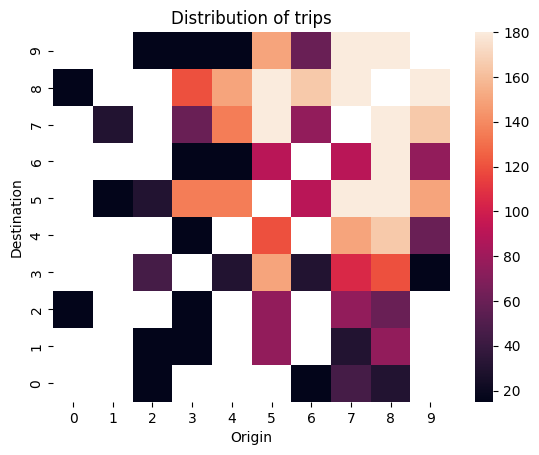

In [10]:
sns.heatmap(pivot_df.iloc[::-1], annot=False, fmt="d")
plt.title('Distribution of trips')
plt.xlabel(pivot_df.columns.name)
plt.ylabel(pivot_df.index.name)
plt.show()

In [11]:
mean_demand_matrix = df.groupby("origin")["demand"].mean().values.reshape(1,pivot_df.shape[1])

In [12]:
mean_demand_matrix

array([[0.06666667, 0.08888889, 0.06666667, 0.07948718, 0.12291667,
        0.39411765, 0.12413793, 0.36811594, 0.75641026, 0.37984496]])

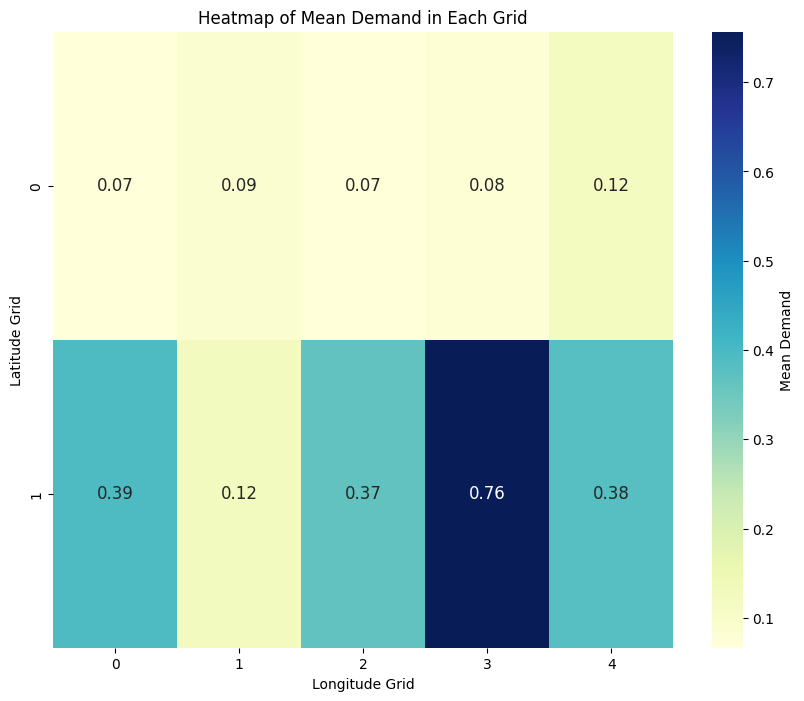

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(mean_demand_matrix.reshape(2,5), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean Demand'}, annot_kws={"size": 12})
plt.title('Heatmap of Mean Demand in Each Grid')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
plt.show()

# Travel time analysis

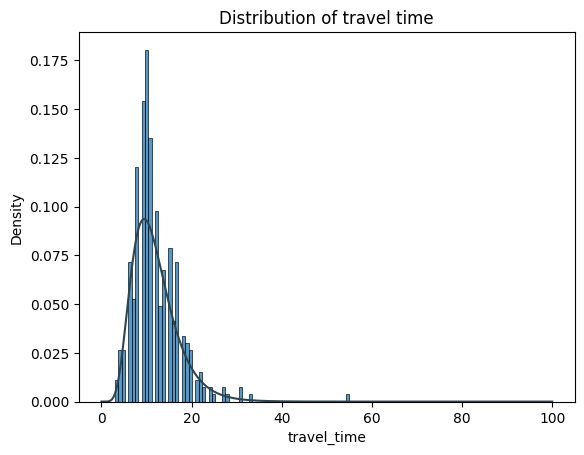

In [14]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["travel_time"])
sns.histplot(df["travel_time"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of travel time")
plt.show()

# Price analysis

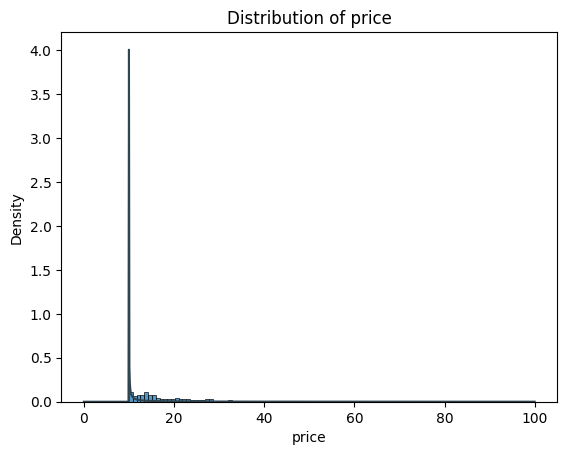

In [15]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["price"])
sns.histplot(df["price"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of price")
plt.show()

In [16]:
pred_df = df.copy()

In [17]:
pred_df["poly_travel_time"] = pred_df["travel_time"]**2
pred_df["poly_demand"] = pred_df["demand"]**2
pred_df["log_price"] = np.log(pred_df["price"])

In [52]:
sc = StandardScaler()

In [75]:
X = sc.fit_transform(df[["price", "travel_time"]])

In [76]:
X.shape

(5370, 2)

In [77]:
X,y = X[:, 1:], X[:,0]

In [78]:
norm_glm = sm.GLM(y, X).fit()

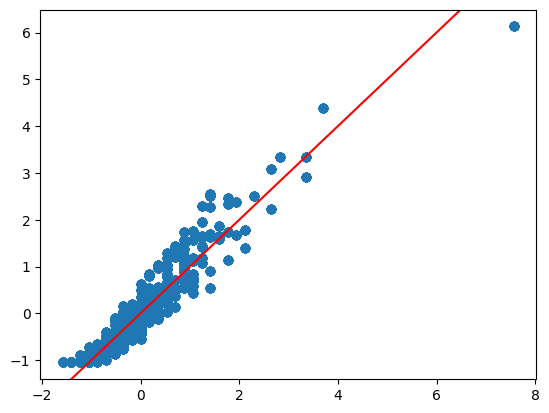

In [79]:
plt.scatter(norm_glm.predict(), y)
plt.axline((0,0), slope=1, color="red")

In [81]:
norm_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 5370
Model:                            GLM   Df Residuals:                     5369
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                         0.10843
Method:                          IRLS   Log-Likelihood:                -1654.1
Date:                Tue, 05 Dec 2023   Deviance:                       582.16
Time:                        14:06:02   Pearson chi2:                     582.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9997
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9442      0.004    210.133      0.000       0.935       0.953
==============================================================================
"""

In [95]:
glm_model = smf.glm(formula="price ~ travel_time", data=pred_df, family=sm.families.Gaussian())

In [96]:
fitted_glm = glm_model.fit()

In [97]:
fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                 5370
Model:                            GLM   Df Residuals:                     5368
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          7.4242
Method:                          IRLS   Log-Likelihood:                -13001.
Date:                Tue, 05 Dec 2023   Deviance:                       39853.
Time:                        14:07:34   Pearson chi2:                 3.99e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9997
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.2684      0.091     13.957      0.000       1.090       1.447
travel_time     1.4547      0.007    210.113      0.000       1.441       1.468
===============================================================================
"""

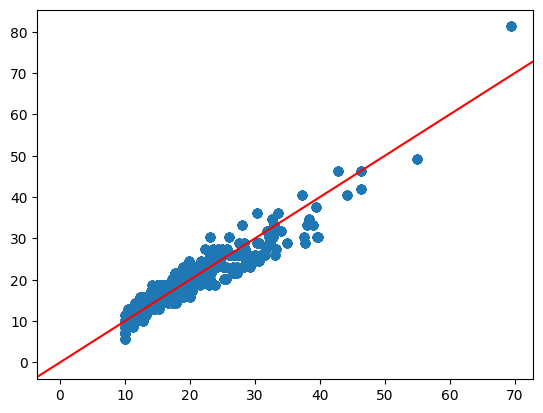

In [104]:
plt.scatter(pred_df["price"], fitted_glm.predict())
plt.axline((0,0), slope=1, color="red")
plt.show()

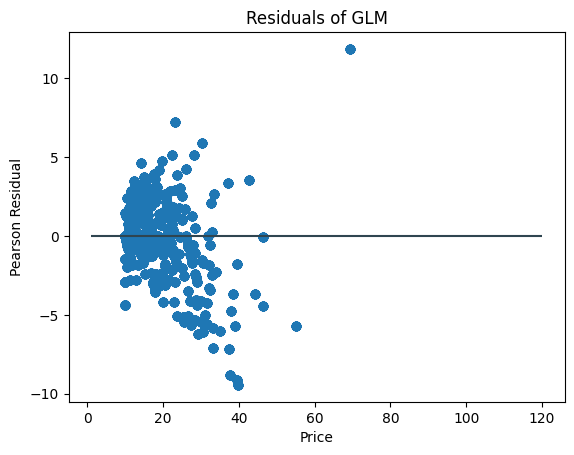

In [103]:
plt.scatter(pred_df["price"], fitted_glm.predict() - pred_df["price"])
plt.hlines(y=0, xmin=1, xmax=120, color="#2F4550")
plt.xlabel("Price")
plt.ylabel("Pearson Residual")
plt.title("Residuals of GLM")
plt.show()

# Predicting demand

In [174]:
def model_2(vars, travel_time):
    alpha, beta = vars
    demand_hat = np.exp(alpha + beta * travel_time)
    return demand_hat

In [175]:
def mse_model2(vars, price, travel_time):
    price_hat = model_2(vars, travel_time)
    return np.mean((price-price_hat)**2)

In [180]:
x0 = (0,0)
res = minimize(mse_model2, x0, args=(df.price, df.travel_time), tol=1e-3, method="Powell")

In [181]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 20.92744780137508
       x: [ 2.447e+00  3.932e-02]
     nit: 4
   direc: [[ 1.000e+00  0.000e+00]
           [-2.373e-01  1.697e-02]]
    nfev: 98

In [182]:
res.x

array([2.44746718, 0.03932451])

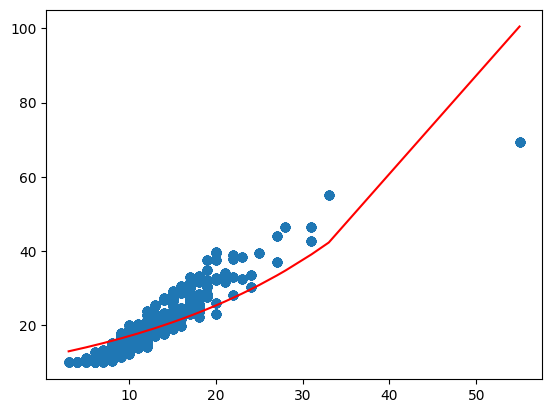

In [183]:
plt.plot(df.travel_time.sort_values(ascending=False).values, model_2(res.x, df.travel_time.sort_values(ascending=False).values), color="red")
plt.scatter(df.travel_time.sort_values(ascending=False).values,df.sort_values("travel_time", ascending=False).price.values)
plt.show()

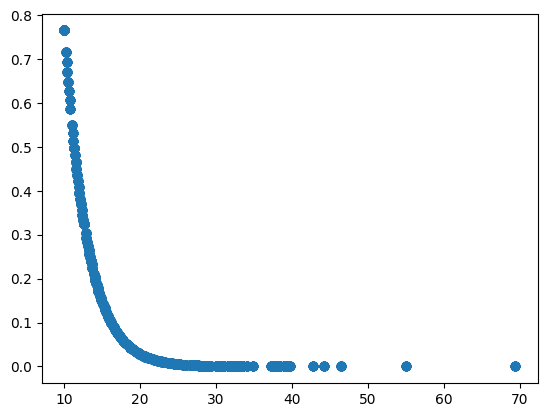

In [108]:
plt.scatter(df["price"], np.exp(res.x[0] + res.x[1] * df["price"]))

In [ ]:
plt.plot(df.price.sort_values(ascending=False).values, model_2(res.x, df.demand.sort_values(ascending=False).values), color="red")
plt.scatter(df.price.sort_values(ascending=False).values,df.sort_values("price", ascending=False).demand.values)